# Generate Geometry

## Method 1

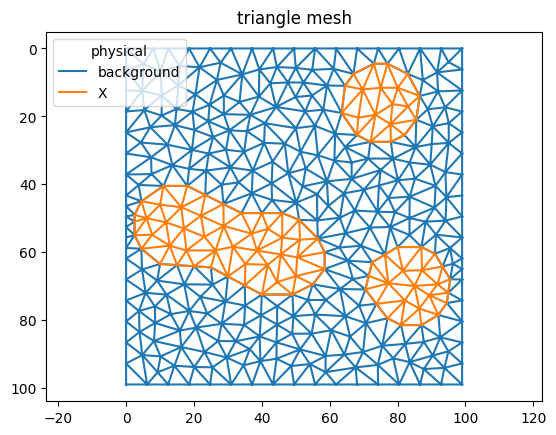

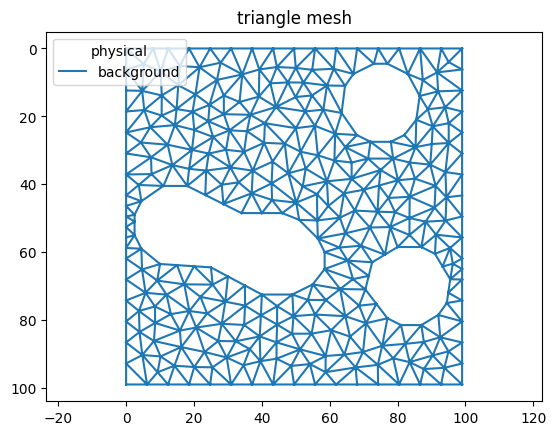

In [24]:
from nanomesh.data import binary_blobs2d
from nanomesh import Mesher

data = binary_blobs2d(length=100, volume_fraction=0.2, blob_size_fraction=0.5)

mesher = Mesher(data)
mesher.generate_contour()

mesh = mesher.triangulate(opts='q30a25')

triangles = mesh.get('triangle')
triangles.plot()

triangles.remove_cells(label=2, key='physical')

triangles.plot()

triangles.write('mesh2d.vol', 'netgen')

## Translate to FEMSolver

In [25]:
from ngsolve import *
from ngsolve.webgui import Draw

mesh = Mesh('mesh2d.vol')

In [26]:
fes = H1(mesh, order=1) # TODO: boundary conditions

u, v = fes.TnT()

f = LinearForm(fes)
f += sin(x) * v * dx

a = BilinearForm(fes)
a += grad(u)*grad(v)*dx

a.Assemble()
f.Assemble()

gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec

Draw (gfu)
Draw (-grad(gfu), mesh, "Flux")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## Method 2

<Axes: title={'center': 'line mesh'}>

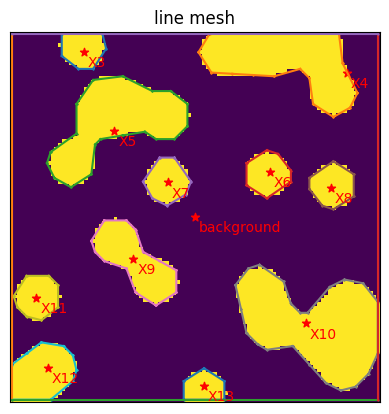

In [20]:
from skimage.data import binary_blobs
from nanomesh import Image, Mesher2D

length = 100
blobs = binary_blobs(length=length, volume_fraction=0.3, blob_size_fraction=0.2)
plane = Image(blobs)

mesh = Mesher2D(plane)
mesh.generate_contour(group_regions=False)

mesh.plot_contour(legend=False)

In [21]:
polygons = []
curr_polygon = []
last_region = mesh.contour.cell_data['segment_markers'][0]
for edge, region in zip(mesh.contour.cells, mesh.contour.cell_data['segment_markers']):
    if region != last_region:
        polygons.append(curr_polygon)
        curr_polygon = [edge]
        last_region = region
    else:
        curr_polygon.append(edge)

In [22]:
from ipycanvas import Canvas, hold_canvas
grid_size = 416
canvas = Canvas(width=grid_size, height=grid_size)
colors = ['red', 'blue', 'black']
with hold_canvas():
    for i, polygon in enumerate(polygons):
        if len(polygon) < 3:
            continue
        for edge in polygon:
            A, B = (mesh.contour.points[edge] / length) * grid_size
            canvas.stroke_style = colors[i % len(colors)]
            canvas.stroke_line(A[0], A[1], B[0], B[1])
canvas

Canvas(height=416, width=416)

## Translate to FEM